In [1]:
import torch

__all__ = ['get_softmax_uncertainty_distance']

def get_softmax_uncertainty_distance(pred,mask = None):
  """
  pred: BS,C,H,W before softmax is applied! 
  
  distance between sec and first element
  # 1 if fully uncertain -> 2th best pixel estimate = 1th best pixel estimate, for all pixels
  # 0 if absolutly confident for all pixels. One class probability 1, 2th best class probability 0, for all pixels
  """
  BS,C,H,W = pred.shape
  if mask is None:
    mask = torch.ones( (BS,H,W), device=pred.device, dtype=torch.bool)
    
  argm1 = torch.argmax(pred, 1)
  soft1 = torch.nn.functional.softmax(pred, dim=1)

  onehot_argm1 = torch.nn.functional.one_hot(argm1, num_classes=C).permute(0,3,1,2).type(torch.bool)
  ten2 = pred.clone()
  ten2[ onehot_argm1 ] = 0

  argm2 = torch.argmax(ten2, 1)
  onehot_argm2 = torch.nn.functional.one_hot(argm2, num_classes=C).permute(0,3,1,2).type(torch.bool)
  res = [] 

  soft1 = soft1.permute(0,2,3,1)
  onehot_argm1 = onehot_argm1.permute(0,2,3,1)
  onehot_argm2 = onehot_argm2.permute(0,2,3,1)
  
  for b in range(BS):
    res_ = soft1[b][mask[b]][onehot_argm1[b][mask[b]]] - soft1[b][mask[b]][onehot_argm2[b][mask[b]]]
    res.append( res_.mean() )

  return torch.tensor(res, dtype=pred.dtype, device=pred.device)


def test():
  BS,C,H,W = 16,40,300,320
  mask = torch.rand( ( BS,H,W) ) > 0.5
    
  pred = torch.rand( ( BS,C,H,W) )
  res = get_softmax_uncertainty_distance(pred)
  print(res, "should be very low")
  
  pred = torch.rand( ( BS,C,H,W) ) /1000
  pred[:,0,:,:] = 10
  res = get_softmax_uncertainty_distance(pred, mask)
  print(res, 'should be nearly 0')
  
  pred[:,1,:,:] = 8
  res = get_softmax_uncertainty_distance(pred, mask)
  print(res, 'should be betweem 0-1')
test()

tensor([0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009]) should be very low
tensor([0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982,
        0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982]) should be nearly 0
tensor([0.7604, 0.7604, 0.7604, 0.7604, 0.7604, 0.7604, 0.7604, 0.7604, 0.7604,
        0.7604, 0.7604, 0.7604, 0.7604, 0.7604, 0.7604, 0.7604]) should be betweem 0-1


In [3]:
def get_softmax_uncertaintiy_max(pred):
    """
    pred: BS,C,H,W before softmax is applied! 
    
    (1 - max( softmax(pred))) mean over batch size
    
    # 1 if fully uncertain
    # 0 if absolutly confident for all pixels
    """
    BS,C,H,W = pred.shape
    
    argm1 = torch.argmax(pred, 1)
    soft1 = torch.nn.functional.softmax(pred, dim=1)
    onehot_argm1 = torch.nn.functional.one_hot(argm1, num_classes=C).permute(0,3,1,2).type(torch.bool)
    
    soft1 = soft1.permute(0,2,3,1)
    onehot_argm1 = onehot_argm1.permute(0,2,3,1)
    
    res = []
    for b in range(BS):
        res_ = soft1[b][onehot_argm1[b]]
        res.append( torch.mean(res_)  )
#     print(res)
    return torch.tensor(res, dtype=pred.dtype, device=pred.device)

def test():
    BS,C,H,W = 16,40,300,320
    pred = torch.rand( ( BS,C,H,W) )
    res = get_softmax_uncertaintiy_max(pred)
    print(res, "should be very low")
    
    pred = torch.rand( ( BS,C,H,W) ) /1000
    pred[:,0,:,:] = 10
    res = get_softmax_uncertaintiy_max(pred)
    print(res, 'should be nearly 0')
    
    pred[:,1,:,:] = 8
    res = get_softmax_uncertaintiy_max(pred)
    print(res, 'should be betweem 0-1')
    

test()

tensor([0.0387, 0.0387, 0.0387, 0.0387, 0.0387, 0.0387, 0.0387, 0.0387, 0.0387,
        0.0387, 0.0387, 0.0387, 0.0387, 0.0387, 0.0387, 0.0387]) should be very low
tensor([0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982,
        0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982]) should be nearly 0
tensor([0.8795, 0.8795, 0.8795, 0.8795, 0.8795, 0.8795, 0.8795, 0.8795, 0.8795,
        0.8795, 0.8795, 0.8795, 0.8795, 0.8795, 0.8795, 0.8795]) should be betweem 0-1


In [4]:
onehot_sel = torch.nn.functional.one_hot(sel, num_classes=C).permute(0,3,1,2)
ten2[ onehot_sel ] = 0

#ten2[soft] = 0

NameError: name 'sel' is not defined

In [ ]:
ten = torch.rand( ( 100 ) )
res = torch.topk( ten, 2 )
res.values

res.indices.shape
print( res.indices )
#torch.topk(input, buffer_size, dim=None, largest=True, sorted=True, *, out=None)

In [ ]:
from torchvision.utils import make_grid
import os
os.chdir('/home/jonfrey/ASL')
import sys
sys.path.append('/home/jonfrey/ASL/src')
from visu import Visualizer


images = [torch.rand((3,480,640)) for i in range(16)]
labels = [torch.randint(-1,40,(3,480,640)) for i in range(16)]

grid_images = make_grid(images,nrow = 4,padding = 2,
         scale_each = False, pad_value = 0)
grid_labels = make_grid(labels,nrow = 4,padding = 2,
         scale_each = False, pad_value = -1)

print( grid_labels.shape)

visu = Visualizer( p_visu='/home/jonfrey/tmp', logger=None, epoch=0, store=False, num_classes=40)
visu.plot_image(grid_images, jupyter=True)
visu.plot_segmentation( seg = grid_labels[0], jupyter=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
ten = torch.rand( ( 100 ) )

def plot_hist(data, nr_bins=5, x_label='X', y_label='Y', title='Histogramm'):
    if len(data.shape)>1:
        if data.shape[0] == 0:
            data = data[0,:]
        elif data.shape[1] == 0:
            data = data[:,0]
        else:
            raise Exception('plot_hist: Invalid Data Shape')
    if type(data) == torch.Tensor:
        data = list( data.clone().cpu())
    elif type(data) == np.array:
        data = list(data)
    elif type(data) == list:
        pass
    else:
        raise Exception("plot_hist: Unknown Input Type"+str(type(data)))
    
    # the histogram of the data
    n, bins, patches = plt.hist(x = data, bins= nr_bins, density=True, facecolor='g', alpha=0.75)
    print(bins)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_hist(ten)
print(ten)

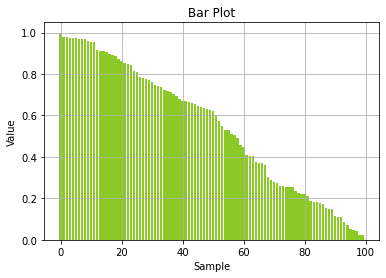

tensor([0.2581, 0.2524, 0.9119, 0.0460, 0.8499, 0.7023, 0.1169, 0.9112, 0.1089,
        0.0243, 0.2526, 0.9709, 0.2549, 0.9992, 0.9805, 0.0737, 0.6955, 0.4037,
        0.5299, 0.6244, 0.5034, 0.3773, 0.7623, 0.7471, 0.4476, 0.6471, 0.8608,
        0.2137, 0.4025, 0.1485, 0.7175, 0.2211, 0.3698, 0.3052, 0.4934, 0.0858,
        0.9077, 0.2197, 0.1499, 0.7350, 0.7133, 0.7848, 0.8878, 0.6226, 0.6008,
        0.8119, 0.7773, 0.6544, 0.9677, 0.9741, 0.3704, 0.0439, 0.7230, 0.8726,
        0.8911, 0.9157, 0.8134, 0.6662, 0.6689, 0.2352, 0.9567, 0.1823, 0.5100,
        0.9720, 0.0498, 0.7706, 0.9543, 0.4570, 0.1837, 0.5491, 0.6360, 0.2761,
        0.6697, 0.2256, 0.1877, 0.1083, 0.9674, 0.1747, 0.6785, 0.0251, 0.8450,
        0.4104, 0.9609, 0.7401, 0.3610, 0.1791, 0.8511, 0.9767, 0.2903, 0.2771,
        0.6601, 0.6332, 0.9728, 0.1515, 0.5293, 0.7806, 0.8987, 0.2620, 0.6395,
        0.5747])

In [164]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
ten = torch.rand( ( 100 ) )
col = { "red":[255,89,94],
 "yellow":[255,202,58],
 "green":[138,201,38],
 "blue":[25,130,196],
 "purple":[106,76,147] }

li = [ [*(v),255] for v in col.values()]
li = (np.array(li)/255).tolist()
COL_MAP = cm.colors.ListedColormap(li)
COL_MAP(0)

def plot_bar(data, nr_bins=5, x_label='Sample', y_label='Value', title='Bar Plot', sort=True, reverse=True):
    def check_shape(data):
        if len(data.shape)>1:
            if data.shape[0] == 0:
                data = data[0,:]
            elif data.shape[1] == 0:
                data = data[:,0]
            else:
                raise Exception('plot_hist: Invalid Data Shape')
        return data
    
    if type(data) == list:
        pass
    elif type(data) == torch.Tensor:
        data = check_shape(data)
        data = list( data.clone().cpu())
    elif type(data) == np.ndarray:
        data = check_shape(data)
        data = list(data)
    else:
        raise Exception("plot_hist: Unknown Input Type"+str(type(data)))
    
    if sort:
        data.sort(reverse=reverse)
    c = [106,76,147]
    
    col = { "red":[255,89,94],
     "yellow":[255,202,58],
     "green":[138,201,38],
     "blue":[25,130,196],
     "purple":[106,76,147] }

    li = [ [*(v),255] for v in col.values()]
    li = (np.array(li)/255).tolist()
    col_map = cm.colors.ListedColormap(li)

    fig = plt.figure()
    # n, bins, patches = plt.hist(x = data, bins= nr_bins, density=True, facecolor='g', alpha=0.75)
    plt.bar(list(range(len(data))), data, facecolor=COL_MAP(2))
    lab = [ 'ID'+ str(i) for i in range(len(data)) ]

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()
    fig.show()
    plt.close()
plot_bar(ten.numpy())
# print(ten)
ten
# x = np.arange(4)
# money = [1.5e5, 2.5e6, 5.5e6, 2.0e7]


# def millions(x, pos):
#     'The two args are the value and tick position'
#     return '$%1.1fM' % (x * 1e-6)


# formatter = FuncFormatter(millions)

# fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)

# plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
# plt.show()

(1.0, 0.34901960784313724, 0.3686274509803922, 1.0)

In [ ]:
import cv2
from PIL import Image
# img = np.array(f['dataset'])
# img[img > 1] = 1
i =5
p = f'/media/scratch2/jonfrey/datasets/mlhypersim/ai_026_001/images/scene_cam_00_final_hdf5/frame.000{i}.color.hdf5'
import h5py
with h5py.File(p, 'r') as f:
    img = np.array(f['dataset'])

img = torch.from_numpy(img).type(torch.float32) #.permute( 2, 0, 1)  # C H W
img[img>1] = 1
img = img.numpy()
print(img.max(), img.min() )
H,W,C = img.shape

img = img*255
img = np.uint8(img)
out = cv2.resize( img , dsize=(int(W/2), int(H/2)), interpolation=cv2.INTER_CUBIC)
#out = np.moveaxis(out, [0, 1, 2], [2, 1, 0])
print(out.max(), out.shape, out.dtype)
# out = np.uint8(out)
display(Image.fromarray(out))

np.float32( out )/255 

In [ ]:
indi, counts = torch.unique( torch.randint(0,40,(100,1)) , return_counts = True)


plot_bar(counts.numpy())

In [125]:
p = "/media/scratch1/jonfrey/models/master_thesis/dev/uncertainty_integration/latent_feature_tensor_0.pt"
data = torch.load( p )

In [132]:
data.shape


/home/jonfrey/miniconda3/envs/track3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  


tensor([[ 0.,  1.,  2.,  ..., 37., 38., 39.]])

/home/jonfrey/miniconda3/envs/track3/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
/home/jonfrey/miniconda3/envs/track3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  


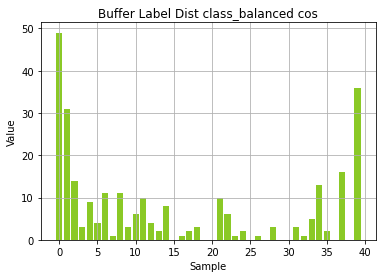

/home/jonfrey/miniconda3/envs/track3/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


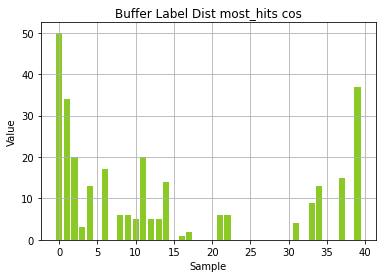

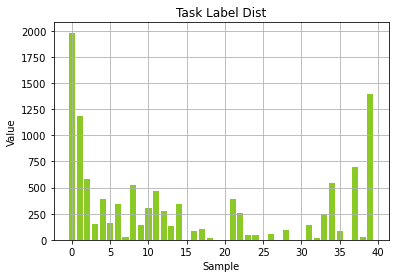

In [203]:
from torch.nn import functional as F

def get_image_indices(feat, gloable_indices, dis_metric= 'cos',
                     K_aggregate=50, K_return=50, most_dissimilar= True,
                     pick_mode='class_balanced'):
    N, NC, C = feat.shape   
    T = int(N*NC)
    y = torch.range(0,NC-1)[None].repeat(N,1).flatten()
    
    gloable_indices_all = gloable_indices[:,None].repeat(1,NC).flatten()
    feat = feat.view( (T,C) )
    
    # only mark a features as valid if the vector is not 0!
    y[ feat.sum(dim=1) == 0 ] = 999
    
    # create centroids over valid features
    feat_centroids = torch.zeros( (NC,C), device=feat.device, dtype=feat.dtype)
    for i in range(NC):
        feat_centroids[i] = feat[y==i].mean(dim=0)
        
    # create expanded centroid tensor that aligns with feat
    expanded_centroids = feat.clone()
    for i in range(NC):
        m = y == i
        expanded_centroids[ m,: ] = feat_centroids[i][None,:].repeat(T,1)[m, :]
    
    # compute similarity metric
    if dis_metric == 'cos':
        metric = F.cosine_similarity(
            feat.type(torch.float32), 
            expanded_centroids.type(torch.float32),
            dim=1, eps=1e-6) 
    elif dis_metric == 'pairwise':
        metric = F.pairwise_distance(
            feat.type(torch.float32), 
            expanded_centroids.type(torch.float32),
            dim=1, eps=1e-6)
    else:
        raise Exception(f'In get_image_indices dis_metric {dis_metric} not implemented')
    
    if pick_mode== 'most_hits':

        # select K best for each class
        candidates = []
        for i in range(NC):
            m = y==i
            _K = min(m.sum(), K_aggregate)
            values, indices = torch.topk( metric[m] ,_K, 
                largest = not most_dissimilar)
            candidates +=  gloable_indices_all[m][indices].tolist()
        candidates = torch.tensor( candidates )

        # select the globale_image_indicies that are selected most
        indi, counts = torch.unique(candidates, return_counts=True, sorted=False)

        values, indices_of_indices = torch.topk( counts ,K_return) 
        ret_globale_indices = gloable_indices[indices_of_indices]
    
    elif pick_mode == 'class_balanced':
        candidates = []
        nr_features_valid = (y!=999).sum()
        
        for i in range(NC):
            m = y==i
            nr_features_valid_i = (y==i).sum()
            
            factor = float( nr_features_valid_i/nr_features_valid)
            if i == NC-1:
                _K = int(K_return-len(candidates))
            else:
                _K = int( K_return*factor )
                
            if _K > 0:
                max_ele = metric[m].shape[0]
                top_K = min(max_ele, _K+ len(candidates)+1)
                
                values, indices = torch.topk( metric[m] ,_K, 
                    largest = not most_dissimilar)
                added = 0
                for ele in gloable_indices_all[m][indices].tolist():
                    if not ele in candidates and added < _K:
                        added += 1
                        candidates = candidates + [int(ele)]
                
        if len(candidates) > K_return:
            candidates = candidates[:K_return]
        
        # select the globale_image_indicies that are selected most
        ret_globale_indices = torch.tensor(candidates)
        
    return ret_globale_indices
    
ret_gloable_indices = get_image_indices(data, torch.range(0,data.shape[0]-1))
classes = torch.zeros( (data.shape[1]) )
for i in range(ret_gloable_indices.shape[0]):
    idx = int( ret_gloable_indices[i] )
    for n in range( data.shape[1] ):
        if data[idx,n,:].sum() != 0:
            classes[n] += 1
plot_bar(classes.numpy(), sort=False, title='Buffer Label Dist class_balanced cos')

ret_gloable_indices = get_image_indices(data, torch.range(0,data.shape[0]-1), pick_mode='most_hits')
classes = torch.zeros( (data.shape[1]) )
for i in range(ret_gloable_indices.shape[0]):
    idx = int( ret_gloable_indices[i] )
    for n in range( data.shape[1] ):
        if data[idx,n,:].sum() != 0:
            classes[n] += 1
plot_bar(classes.numpy(), sort=False, title='Buffer Label Dist most_hits cos')


classes = torch.zeros( (data.shape[1]) )
for i in range(data.shape[0]):
    idx = int(i)
    for n in range( data.shape[1] ):
        if data[idx,n,:].sum() != 0:
            classes[n] += 1
            
plot_bar(classes.numpy(), sort=False, title='Task Label Dist')

In [106]:
elements = []
yy = []

image_idx = []

#creates hierachical list of all feature vectors
for ne in range(data.shape[1]):
    classes = []
    labels = []
    for i in range(data.shape[0]):
        if data[i,ne].sum() != 0:
            image_idx.append( i )
            classes.append( data[i,ne] )
            labels.append(ne)
    yy.append(labels)
    print(len(classes))
    elements.append( classes )

len( image_idx )

1982
1185
586
154
393
165
344
25
529
142
302
470
280
131
340
0
80
107
15
0
0
393
253
42
46
0
57
0
94
0
0
145
18
244
547
85
0
694
26
1394


11268

In [101]:
# flatten the hierachical list

ele = 0
for e in elements:
    ele += len(e)
X = torch.zeros( (ele,128))
y = torch.zeros( (ele) )

s = 0
for e in elements:
    for i in e:
        X[s] = i
        s+=1 
        
s = 0
for e in yy:
    for i in e:
        y[s] = i
        s+=1 

X = X.numpy()
y = y.numpy()

In [102]:
X.shape, y.shape

((11268, 128), (11268,))

In [8]:
import numpy as np
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components=2)
pca.fit(X,y)
X_pca = pca.transform(X)

In [10]:
X.shape, X_pca.shape, X_pca[y==0].shape

X_pca[y==0].shape, y[y==0].shape

((1982, 2), (1982,))

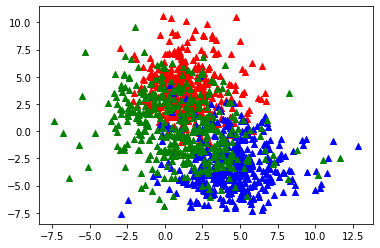

None

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility

N = 100
r0 = 0.6
col = ['r','b','g','y','r','b','g','y']
ma = ['^','^','^','^','o','o','o','o']
nr = 400
for i in range(3):
    if X_pca[y==i,0].shape[0] > nr:
        plt.scatter(X_pca[y==i,0][:nr], X_pca[y==i,1][:nr], marker='^', c=col[i])
    else:
        plt.scatter(X_pca[y==i,0], X_pca[y==i,1], marker='^', c=col[i])
        
display( plt.show() )

/home/jonfrey/miniconda3/envs/track3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jonfrey/miniconda3/envs/track3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


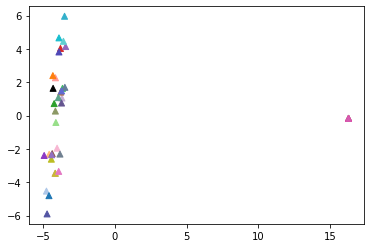

None

In [91]:
X_centroids = np.zeros( (data.shape[1],data.shape[2]) )
for i in range(data.shape[1]):
    X_centroids[i] = X[y==i].mean(axis=0)
    
X_centroids [ np.isnan(X_centroids) ] = 0
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

pca = PCA(n_components=2)
pca.fit(X_centroids)
X_centroids_pca = pca.transform(X_centroids)

plt.scatter(X_centroids_pca[:,0], X_centroids_pca[:,1], marker='^', c=col)

display( plt.show() )

In [124]:
from torch import nn
try:
    y = torch.from_numpy( y ).type(torch.int64)
    X_centroids = torch.from_numpy( X_centroids ).type(torch.float16)
except:
    pass
accum = torch.zeros( (*X.shape), dtype=torch.float16 )

#create the accum tensor with the same size as the full dataset filled with the centroids
for cen in range(X_centroids.shape[0]):
    m = y == cen
    accum[ m,: ] =  X_centroids[cen][None,:].repeat(accum.shape[0],1)[m, :]


cos = nn.CosineSimilarity(dim=1, eps=1e-6)
simil = cos(torch.from_numpy(X).type(torch.float32), accum.type(torch.float32))

print(simil)
K = 50
image_idx = torch.tensor( image_idx )
candidates = []
for cen in range(X_centroids.shape[0]):
    # take the minus for least similar samples
    m = y==cen
    values, indices = torch.topk( -simil[m] ,min(m.sum(), K)) 
    candidates += image_idx[m][indices].tolist()

candidates = torch.tensor( candidates )
indi, counts = torch.unique(candidates, return_counts=True, sorted=False)
K_ = 50
values, indices_of_indices = torch.topk( counts ,K_) 
final_results_of_image_indexes = indi[indices_of_indices]

tensor([0.9420, 0.9629, 0.9217,  ..., 0.9207, 0.9718, 0.8641])


/home/jonfrey/miniconda3/envs/track3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [100]:
m = y == cen 
torch.where(m)[0][0]
accum[torch.where(m)[0][0]] - accum[torch.where(m)[0][100]] 
#LGTM
accum.shape, X.shape

(torch.Size([11268, 128]), (11268, 128))

(40, 3)

In [46]:
SCANNET_COLOR_MAP = {
    0: (0.0, 0.0, 0.0),
    1: (174.0, 199.0, 232.0),
    2: (152.0, 223.0, 138.0),
    3: (31.0, 119.0, 180.0),
    4: (255.0, 187.0, 120.0),
    5: (188.0, 189.0, 34.0),
    6: (140.0, 86.0, 75.0),
    7: (255.0, 152.0, 150.0),
    8: (214.0, 39.0, 40.0),
    9: (197.0, 176.0, 213.0),
    10: (148.0, 103.0, 189.0),
    11: (196.0, 156.0, 148.0),
    12: (23.0, 190.0, 207.0),
    14: (247.0, 182.0, 210.0),
    15: (66.0, 188.0, 102.0),
    16: (219.0, 219.0, 141.0),
    17: (140.0, 57.0, 197.0),
    18: (202.0, 185.0, 52.0),
    19: (51.0, 176.0, 203.0),
    20: (200.0, 54.0, 131.0),
    21: (92.0, 193.0, 61.0),
    22: (78.0, 71.0, 183.0),
    23: (172.0, 114.0, 82.0),
    24: (255.0, 127.0, 14.0),
    25: (91.0, 163.0, 138.0),
    26: (153.0, 98.0, 156.0),
    27: (140.0, 153.0, 101.0),
    28: (158.0, 218.0, 229.0),
    29: (100.0, 125.0, 154.0),
    30: (178.0, 127.0, 135.0),
    31: (255.0, 0.0, 135.0),
    32: (146.0, 111.0, 194.0),
    33: (44.0, 160.0, 44.0),
    34: (112.0, 128.0, 144.0),
    35: (96.0, 207.0, 209.0),
    36: (227.0, 119.0, 194.0),
    37: (213.0, 92.0, 176.0),
    38: (94.0, 106.0, 211.0),
    39: (82.0, 84.0, 163.0),
    40: (100.0, 85.0, 144.0),
}
col = np.array( [v for v in SCANNET_COLOR_MAP.values()] )/255
